In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [3]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [33]:
with open('../data/filtered/bmi_steps.pickle', 'rb') as f:
    steps_bmi = pd.DataFrame(pickle.load(f))

In [34]:
printmd('**Data Overview**')
steps_bmi.head()

**Data Overview**

,user_id,year,month,day,steps,bmi
41,000d49c2-9b5d-4718-94bc-78b90ed48290,2016,10,28,1135,22.938962
42,000d49c2-9b5d-4718-94bc-78b90ed48290,2016,10,29,4029,22.938962
43,000d49c2-9b5d-4718-94bc-78b90ed48290,2016,10,30,14596,22.938962
44,000d49c2-9b5d-4718-94bc-78b90ed48290,2016,10,31,18017,22.938962
45,000d49c2-9b5d-4718-94bc-78b90ed48290,2016,11,1,11165,22.938962


In [35]:
printmd('**Global bmi, steps correlation**')
steps_bmi[['steps','bmi']].corr()

**Global bmi, steps correlation**

,steps,bmi
steps,1.000000,-0.150802
bmi,-0.150802,1.000000


In [81]:
# Individual bmi, steps correlation
user_ids = steps_bmi.user_id.unique()
steps_bmi_user_corr = []
for user in user_ids:
    steps_bmi_user = steps_bmi[steps_bmi.user_id==user]
    corr = steps_bmi_user[['steps','bmi']].corr()['steps']['bmi']
    steps_bmi_user_corr.append(corr)

**Individual bmi, steps correlation**

* _Best correlation:_ -1.0000000000000002

* _Worse correlation:_ 1.0000000000000002

* _Mean correlation:_ -0.05716623057492115

* _Standard Deviation:_ 0.4631324396301748 

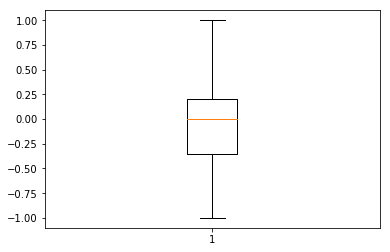

In [93]:
printmd('**Individual bmi, steps correlation**')
steps_bmi_user_corr = np.array(steps_bmi_user_corr)
printmd('* _Best correlation:_ {}'.format(np.nanmin(steps_bmi_user_corr)))
printmd('* _Worse correlation:_ {}'.format(np.nanmax(steps_bmi_user_corr)))
printmd('* _Mean correlation:_ {}'.format(np.nanmean(steps_bmi_user_corr)))
printmd('* _Standard Deviation:_ {} '.format(np.nanstd(steps_bmi_user_corr)))
indexes = ~np.isnan(steps_bmi_user_corr)
plt.clf()
plt.boxplot(steps_bmi_user_corr[indexes], 0)
plt.show()

**Visualize user data with negative steps, bmi correlation**

* Number of users with negative steps, bmi correlation (<=0.7): 199 (4.81%)

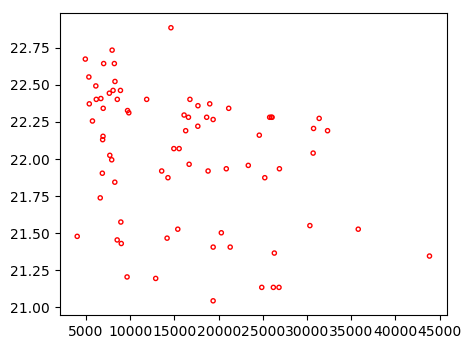

In [99]:
printmd('**Visualize user data with negative steps, bmi correlation**')
indexes = ~np.isnan(steps_bmi_user_corr)
user_idx = np.where( steps_bmi_user_corr[indexes] <= -0.7) [0]
len_users = len(steps_bmi_user_corr)
printmd('* Number of users with negative steps, bmi correlation (<=0.7): {} ({}%)'.format(
    len(user_idx), "%.2f" % ( (len(user_idx)/len_users)*100)))

max_entries = 0
user_id = -1
for idx in user_idx:
    user_id_tmp = user_ids[idx]
    steps_bmi_user = steps_bmi[steps_bmi.user_id==user_id_tmp]
    if len(steps_bmi_user) > max_entries:
        max_entries = len(steps_bmi_user)
        user_id = user_id_tmp

steps_bmi_user = steps_bmi[steps_bmi.user_id==user_id]
plt.scatter(steps_bmi_user['steps'], steps_bmi_user['bmi'], 
marker='.', facecolors='none', edgecolors='r')
plt.show()
plt.figure(figsize=(5, 4), dpi=100)

**Visualize user data with positive steps, bmi correlation**

* Number of users with positive steps, bmi correlation (>=0.7): 146 (3.53%)

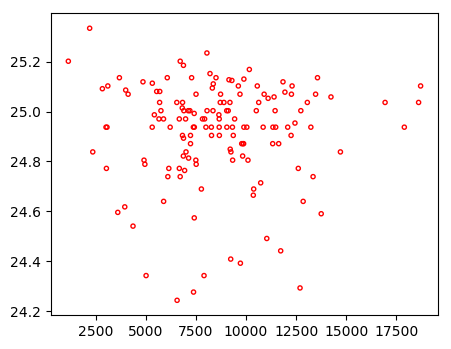

In [100]:
printmd('**Visualize user data with positive steps, bmi correlation**')
user_idx = np.where( steps_bmi_user_corr[indexes] >= 0.7) [0]
printmd('* Number of users with positive steps, bmi correlation (>=0.7): {} ({}%)'.format(
    len(user_idx), "%.2f" % ( (len(user_idx)/len_users)*100)))

max_entries = 0
user_id = -1
for idx in user_idx:
    user_id_tmp = user_ids[idx]
    steps_bmi_user = steps_bmi[steps_bmi.user_id==user_id_tmp]
    if len(steps_bmi_user) > max_entries:
        max_entries = len(steps_bmi_user)
        user_id = user_id_tmp

steps_bmi_user = steps_bmi[steps_bmi.user_id==user_id]
plt.scatter(steps_bmi_user['steps'], steps_bmi_user['bmi'], 
marker='.', facecolors='none', edgecolors='r')
plt.show()
plt.figure(figsize=(5, 4), dpi=100)